# POPVAE

In [ ]:
cd  "C:\Users\silvi\Desktop\Fisica\TESI\popvae"

import tensorflow.keras as keras
import numpy as np 
import os 
import allel
import pandas as pd
import time
import random
import zarr, subprocess, h5py, re, sys, argparse
from matplotlib import pyplot as plt
from tqdm import tqdm
#from keras.models import Sequential
from tensorflow.keras import layers
#from keras.layers.core import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow
import matplotlib.pyplot as plt
import json

load euromds dataset

In [149]:
data = json.load(open(infile,'r'))
data = np.array(data)
# exclude duplicate rows:
data = np.unique(data,axis=0)

#true_labels = json.load(open('data/euromds/euromds_labels.json','r'))
#true_labels = np.array(true_labels)
#data_with_labels = np.hstack([data,true_labels.reshape((len(true_labels),1))])

load model

In [140]:
n_iterations = 6
mean = []
sd = []
sample = []
for i in range(n_iterations):

    args = json.load(open('out/euromds'+str(i)+'/config.json','r')) # stessa configurazione di euromds1

    stddev_epsilon=args['stddev_epsilon']    
    infile=args['infile']
    save_allele_counts=args['save_allele_counts']
    patience=args['patience']
    batch_size=args['batch_size']
    max_epochs=args['max_epochs']
    seed=args['seed']
    save_weights=args['save_weights']
    train_prop=args['train_prop']
    gpu_number=args['gpu_number']
    out=args['out']
    prediction_freq=args['prediction_freq']
    max_SNPs=args['max_SNPs']
    latent_dim=args['latent_dim']
    prune_LD=args['prune_LD']
    prune_iter=args['prune_iter']
    prune_size=args['prune_size']
    PCA=args['PCA']
    PCA_scaler=args['PCA_scaler']
    depth=args['depth']
    width=args['width']
    n_pc_axes=args['n_pc_axes']
    search_network_sizes=args['search_network_sizes']
    plot=args['plot']
    depth_range=args['depth_range']
    depth_range=np.array([int(x) for x in re.split(",",depth_range)])
    width_range=args['width_range']
    width_range=np.array([int(x) for x in re.split(",",width_range)])

    if not seed==None:
        os.environ['PYTHONHASHSEED']=str(seed)
        random.seed(seed)
        np.random.seed(seed)
        tensorflow.set_random_seed(seed)

    os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number


    ### load model

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=stddev_epsilon,seed=seed)
        return z_mean + K.exp(z_log_var) * epsilon

    #encoder
    input_seq = keras.Input(shape=(data.shape[1],))
    x=layers.Dense(width,activation="elu")(input_seq)
    for i in range(depth-1):
        x=layers.Dense(width,activation="elu")(x)
    z_mean=layers.Dense(latent_dim)(x)
    z_log_var=layers.Dense(latent_dim)(x)
    z = layers.Lambda(sampling,output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder=Model(input_seq,[z_mean,z_log_var,z],name='encoder')

    #decoder
    decoder_input=layers.Input(shape=(latent_dim,),name='z_sampling')
    x=layers.Dense(width,activation="linear")(decoder_input)#was elu
    for i in range(depth-1):
        x=layers.Dense(width,activation="elu")(x)
    output=layers.Dense(data.shape[1],activation="sigmoid")(x) #hard sigmoid seems natural here but appears to lead to more left-skewed decoder outputs.
    decoder=Model(decoder_input,output,name='decoder')

    #end-to-end vae
    output_seq = decoder(encoder(input_seq)[2])
    vae = Model(input_seq, output_seq, name='vae')

    reconstruction_loss = keras.losses.binary_crossentropy(input_seq,output_seq)
    reconstruction_loss *= data.shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)


    ### load parameters and append mean, ad and sample 
    vae.load_weights("out/euromds"+str(i)+"/euromds_weights.hdf5")
    #print(vae.get_weights())
    mean.append(encoder(data)[0])
    sd.append(encoder(data)[1])
    sample.append(encoder(data)[2])

In [141]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 128)          7040        input_8[0][0]                    
__________________________________________________________________________________________________
dense_106 (Dense)               (None, 128)          16512       dense_105[0][0]                  
__________________________________________________________________________________________________
dense_107 (Dense)               (None, 128)          16512       dense_106[0][0]                  
____________________________________________________________________________________________

In [142]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_113 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_114 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_115 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_116 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_117 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_118 (Dense)            (None, 128)               1651

In [143]:
vae.summary()

Model: "vae0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 90116       input_8[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 54)           89910       encoder[0][2]                    
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 128)          7040        input_8[0][0]                    
_______________________________________________________________________________________________

load weights

In [154]:
n_iterations = 6
mean = []
sd = []
sample = []
for i in range(n_iterations):
    vae.load_weights("out/euromds"+str(i)+"/euromds_weights.hdf5")
    #print(vae.get_weights())
    mean.append(encoder(data)[0])
    sd.append(encoder(data)[1])
    sample.append(encoder(data)[2])

In [47]:
latent_coords0 = pd.read_csv('out/euromds0/euromds_latent_coords.txt',sep='\t')
latent_coords1 = pd.read_csv('out/euromds1/euromds_latent_coords.txt',sep='\t')

In [ ]:
verify mean and standard deviation

In [49]:
latent_coords0[['mean1','mean2']].iloc[0]

mean1   -0.390397
mean2   -0.044587
Name: 0, dtype: float64

In [50]:
mean0[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.3903967 , -0.04458711], dtype=float32)>

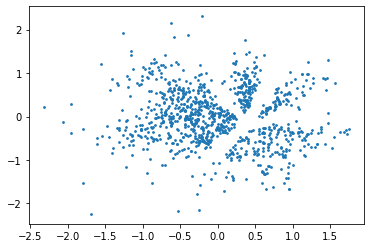

In [67]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.scatter(mean0[:,0],mean0[:,1],s=3)

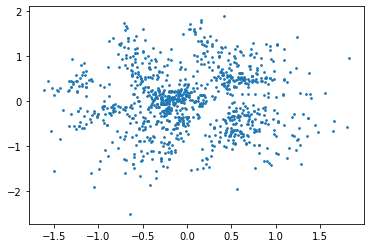

In [68]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.scatter(mean1[:,0],mean1[:,1],s=3)

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as ami
kmeans = KMeans(n_clusters=6)
p0 = kmeans.fit_predict(mean0)
p1 = kmeans.fit_predict(mean1)
print(ami(p0,p1))

df_mean0 = pd.DataFrame(mean0)
df_mean1 = pd.DataFrame(mean1)
df_mean0['label_kmeans'] = p0
df_mean1['label_kmeans'] = p1

0.4689254720123191


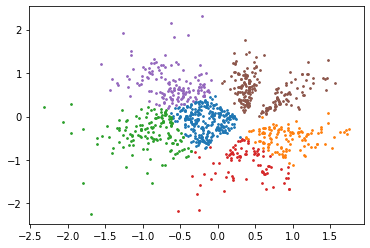

In [113]:
fig,ax = plt.subplots()
for i in range(6):
    ax.scatter(df_mean0.query('label_kmeans=='+str(i))[0],df_mean0.query('label_kmeans=='+str(i))[1],s=3)

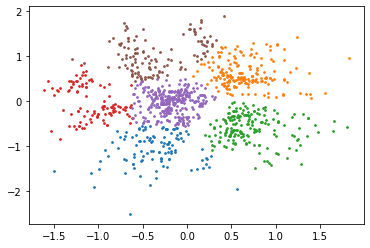

In [112]:
fig,ax = plt.subplots()
for i in range(6):
    ax.scatter(df_mean1.query('label_kmeans=='+str(i))[0],df_mean1.query('label_kmeans=='+str(i))[1],s=3)

In [116]:
from sklearn.cluster import SpectralClustering
#from sklearn.metrics import adjusted_mutual_info_score as ami
sc = SpectralClustering(n_clusters=6)
p0 = sc.fit_predict(mean0)
p1 = sc.fit_predict(mean1)
print(ami(p0,p1))

df_mean0['label_sc'] = p0
df_mean1['label_sc'] = p1

0.38930446286498344


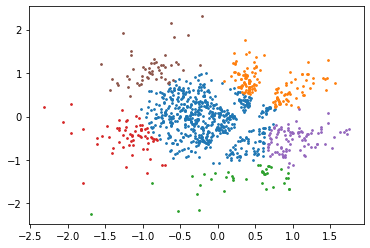

In [118]:
fig,ax = plt.subplots()
for i in range(6):
    ax.scatter(df_mean0.query('label_sc=='+str(i))[0],df_mean0.query('label_sc=='+str(i))[1],s=3)

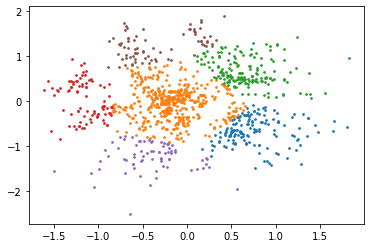

In [117]:
fig,ax = plt.subplots()
for i in range(6):
    ax.scatter(df_mean1.query('label_sc=='+str(i))[0],df_mean1.query('label_sc=='+str(i))[1],s=3)

In [119]:
from scipy.spatial.distance import pdist
d0 = pdist(mean0)
d1 = pdist(mean1)

In [120]:
np.corrcoef(d0,d1)

array([[1.        , 0.52564011],
       [0.52564011, 1.        ]])

In [127]:
cd ..

C:\Users\silvi\Desktop\Fisica\TESI\popvae


In [134]:
x0

,mean1,mean2,sd1,sd2,sampleID
0,-0.390397,-0.044587,-1.812312,-1.476911,0
1,-0.703929,0.100669,-1.752976,-1.474722,1
2,-0.442957,-0.035155,-1.753932,-1.442127,2
3,-0.539569,-0.626833,-2.034461,-1.538498,3
4,-0.541446,0.063796,-1.895381,-1.536274,4
...,...,...,...,...,...
1023,-0.220031,-0.422744,-2.369991,-1.953642,1023
1024,0.184703,0.053948,-2.294230,-2.124947,1024
1025,0.635775,-0.255066,-2.202932,-1.913292,1025
1026,-1.188956,0.854511,-1.825522,-1.972281,1026


In [129]:
x0 = pd.read_csv('out/euromds0/euromds_latent_coords.txt',sep='\t')
x1 = pd.read_csv('out/euromds1/euromds_latent_coords.txt',sep='\t')

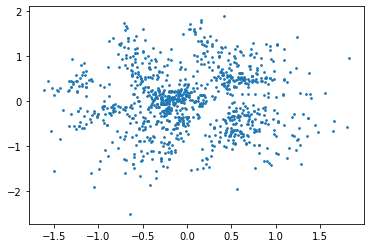

In [132]:
fig,ax = plt.subplots()
ax.scatter(mean1[:,0],mean1[:,1],s=3) 

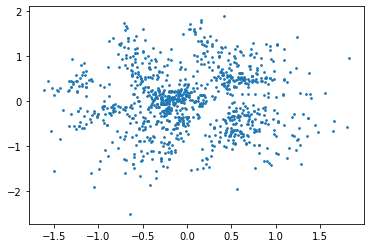

In [135]:
fig,ax = plt.subplots()
ax.scatter(x1['mean1'],x1['mean2'],s=3)

In [138]:
dd0 = pdist(x0[['mean1','mean2']])
dd1 = pdist(x1[['mean1','mean2']])

In [139]:
np.corrcoef(dd0,dd1)

array([[1.        , 0.52564011],
       [0.52564011, 1.        ]])

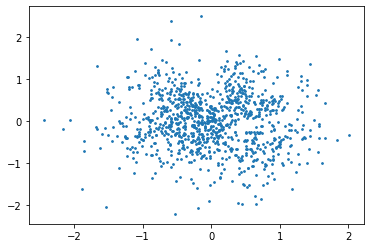

In [114]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.scatter(sample0[:,0],sample0[:,1],s=3)

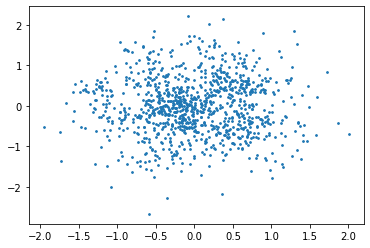

In [115]:
fig,ax = plt.subplots()
ax.scatter(sample1[:,0],sample1[:,1],s=3)

In [146]:
vae.load_weights("out/euromds2/euromds_weights.hdf5")
print(vae.get_weights())
mean2 = encoder(data)[0]
sd2 = encoder(data)[1]
sample2 = encoder(data)[2]

[array([[ 0.13553806, -0.11822788,  0.09326587, ..., -0.02479674,
         0.06700275,  0.04512478],
       [ 0.15304974, -0.00532436,  0.06078392, ..., -0.06402404,
        -0.08085933,  0.0721185 ],
       [-0.17406143,  0.0480649 , -0.10478202, ..., -0.09817057,
        -0.13831773, -0.06725892],
       ...,
       [-0.16116431,  0.12595332, -0.11340844, ..., -0.13206251,
        -0.01566707, -0.01523021],
       [ 0.14890626, -0.15695591, -0.08600555, ...,  0.1850756 ,
        -0.02041095,  0.11901102],
       [-0.10877185, -0.02229978,  0.01581557, ...,  0.08250357,
         0.04528934,  0.10195359]], dtype=float32), array([-0.00261792, -0.03791849, -0.02704925,  0.00411244, -0.02518598,
       -0.01091766,  0.02430261,  0.00209317, -0.00065625, -0.00024458,
       -0.02365097, -0.00997124, -0.00010476, -0.0094801 ,  0.06971857,
        0.02836461,  0.00995148,  0.01086426,  0.00696175,  0.02911674,
       -0.00213401, -0.00377081,  0.02808712,  0.0097047 ,  0.00972295,
       -0.

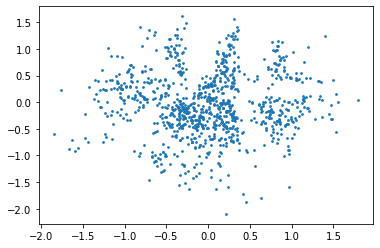

In [147]:
fig,ax = plt.subplots()
ax.scatter(mean2[:,0],mean2[:,1],s=3)

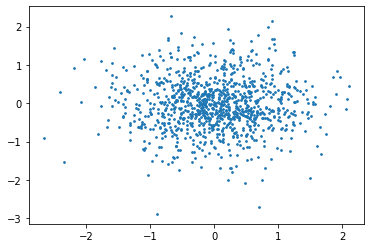

In [148]:
fig,ax = plt.subplots()
ax.scatter(sample2[:,0],sample2[:,1],s=3)

In [ ]:
meglio usare la media invece del sample oppure diminuire la std 

In [ ]:
prova a cambiare dimensione del latent layer e applicare algoritmi di clustering

In [ ]:
controlla che a diversi run le medie e sd siano le stesse ma le samples no